In [2]:
import sbi
import torch
from sbi.neural_nets.net_builders import build_nsf
from torch.optim import AdamW
from sbi.inference.posteriors import DirectPosterior, ImportanceSamplingPosterior
import matplotlib.pyplot as plt
import corner

from sbi.utils import BoxUniform

In [3]:
num_dims = 3

def simulator(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

prior = BoxUniform(low = -2 * torch.ones(num_dims), high = 2 * torch.ones(num_dims))

In [17]:
theta_s = prior.sample((1000,))
x_s = simulator(theta_s)
observation = simulator(torch.tensor([1.0, 1.0, 1.0]))

In [9]:
class EmbeddingNet(torch.nn.Module):
    def __init__(self, in_features=3):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features),
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class NPEData(torch.utils.data.Dataset):
    def __init__(self,
                 num_samples: int,
                 prior: torch.distributions.Distribution,
                 simulator):
        super().__init__()
        self.prior = prior
        self.simulator = simulator

        self.theta = prior.sample((num_samples,))
        self.x = simulator(self.theta)

    def __len__(self):
        return self.theta.shape[0]

    def __getitem__(self, index:int):
        return self.theta[index,...], self.x[index,...]

In [13]:
def build_density_estimator(prior=prior, simulator=simulator):
    embedding_net = EmbeddingNet(in_features=3)
    dummy_data = NPEData(num_samples=64, prior=prior, simulator=simulator)
    density_estimator = build_nsf(
        batch_x=dummy_data.theta,
        batch_y=dummy_data.x,
        embedding_net=embedding_net,
    )
    return density_estimator

In [14]:
def setup_scheduler(optimizer):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=10,
        verbose=True,
        threshold=1e-4,
        threshold_mode='rel',
        cooldown=0,
        min_lr=0,
        eps=1e-8
    )
    return scheduler

In [15]:
train_data = NPEData(num_samples=10_000, prior=prior, simulator=simulator)
val_data = NPEData(num_samples=1_000, prior=prior, simulator=simulator)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

In [34]:
density_estimator = build_density_estimator()
optimizer = AdamW(density_estimator.parameters(), lr=1e-3)
scheduler = setup_scheduler(optimizer)
train_losses = [] 
val_losses = [] 
learning_rates = []
post_samples = []

/Users/james/Code/mambaforge/envs/sbi_acp/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [35]:
import wandb
wandb.init(project="npe")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: j-b-g-alvey to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [36]:
num_epochs = 100
step = 0

for epoch in range(num_epochs):
    density_estimator.train()

    for theta, x in train_dataloader:
        loss = density_estimator.loss(theta, x).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print(f"Epoch {epoch + 1}, train loss: {loss.item()}", end='\r')
        wandb.log({"train_loss": loss.item(), "step": step})
        step += 1


    density_estimator.eval()

    epoch_val_loss = 0.0
    with torch.no_grad():
        for theta, x in val_dataloader:
            epoch_val_loss += density_estimator.loss(theta, x).mean().item()
    
    epoch_val_loss /= len(val_dataloader)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)
    learning_rates.append(scheduler.get_last_lr())
    print(f"Epoch {epoch + 1}, val loss: {epoch_val_loss}")
    wandb.log({"val_loss": epoch_val_loss, "step": step})

Epoch 1, val loss: -1.725646995007991836432
Epoch 2, val loss: -2.332220315933227537
Epoch 3, val loss: -2.576705276966095617
Epoch 4, val loss: -2.480461344122886763
Epoch 5, val loss: -2.325523927807808107
Epoch 6, val loss: -2.634989008307457318
Epoch 7, val loss: -2.521257534623146343
Epoch 8, val loss: -2.632853522896766726
Epoch 9, val loss: -2.538422524929046686
Epoch 10, val loss: -2.572425186634063788
Epoch 11, val loss: -2.427510797977447535
Epoch 12, val loss: -2.660039946436882217
Epoch 13, val loss: -2.621936887502670314
Epoch 14, val loss: -2.356517553329467883
Epoch 15, val loss: -2.600610211491584833
Epoch 16, val loss: -2.570900201797485486
Epoch 17, val loss: -2.489001139998436717
Epoch 18, val loss: -2.663314312696457737
Epoch 19, val loss: -2.652908816933632527
Epoch 20, val loss: -2.680273398756981655
Epoch 21, val loss: -2.525334447622299188
Epoch 22, val loss: -2.660544037818908787
Epoch 23, val loss: -2.671388819813728374
Epoch 24, val loss: -2.68102429807186138

KeyboardInterrupt: 

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 2a5065270, raw_cell="plt.plot(np.linspace(1, len(train_losses), len(tra.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X14sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

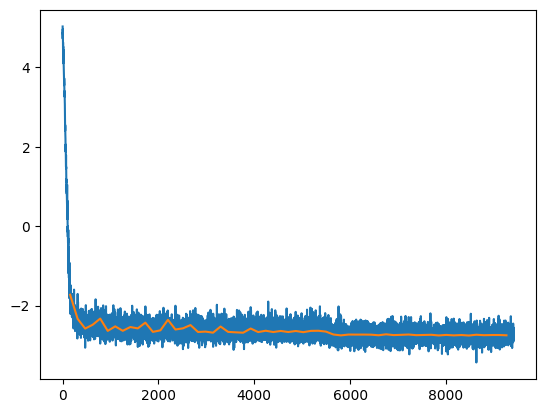

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for post_run_cell), with arguments args (<ExecutionResult object at 2a3afc100, execution_count=40 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2a5065270, raw_cell="plt.plot(np.linspace(1, len(train_losses), len(tra.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X14sZmlsZQ%3D%3D> result=[<matplotlib.lines.Line2D object at 0x1508aed70>]>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [40]:
plt.plot(np.linspace(1, len(train_losses), len(train_losses)), train_losses, label='train loss')
plt.plot(157 * np.linspace(1, len(val_losses), len(val_losses)), val_losses, label='val loss')

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1508bf730, raw_cell="plt.semilogy(157 * np.linspace(1, len(learning_rat.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X22sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

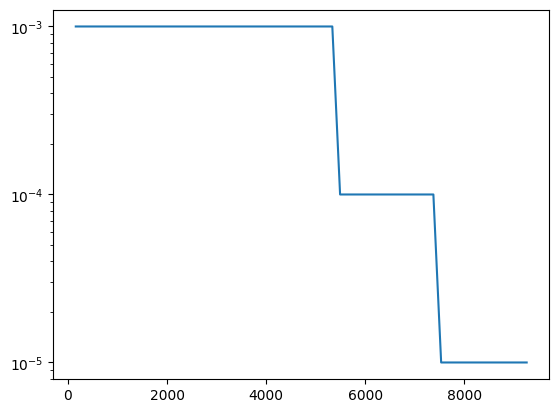

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for post_run_cell), with arguments args (<ExecutionResult object at 1508bfd90, execution_count=41 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1508bf730, raw_cell="plt.semilogy(157 * np.linspace(1, len(learning_rat.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X22sZmlsZQ%3D%3D> result=[<matplotlib.lines.Line2D object at 0x150941d80>]>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [41]:
plt.semilogy(157 * np.linspace(1, len(learning_rates), len(learning_rates)), learning_rates, label='val loss')

In [42]:
posterior = DirectPosterior(density_estimator, prior)
samples = posterior.sample((10_000,), x=observation)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 150a4a3e0, raw_cell="posterior = DirectPosterior(density_estimator, pri.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X16sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for post_run_cell), with arguments args (<ExecutionResult object at 150a4afb0, execution_count=42 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 150a4a3e0, raw_cell="posterior = DirectPosterior(density_estimator, pri.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 150a49f00, raw_cell="corner.corner(samples.numpy(), truths=[1.0, 1.0, 1.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X20sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

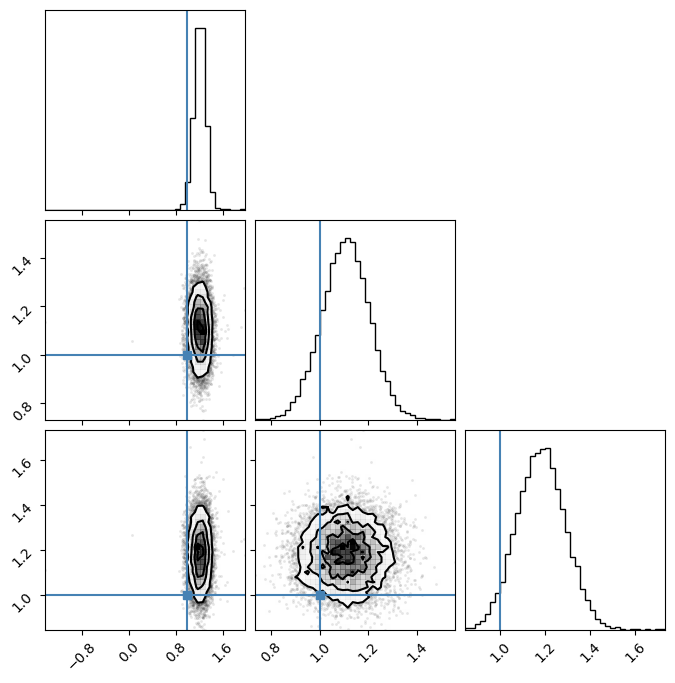

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2a8c9be80>> (for post_run_cell), with arguments args (<ExecutionResult object at 150a49a80, execution_count=43 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 150a49f00, raw_cell="corner.corner(samples.numpy(), truths=[1.0, 1.0, 1.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/james/Dropbox/JimDex/40-49%20Research%20Projects/40%20Software/40.37%20SBI%20ACP/ACP-test/notebooks/sbi_custom_training.ipynb#X20sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [43]:
corner.corner(samples.numpy(), truths=[1.0, 1.0, 1.0], bins=40);